# Import Packages


In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Import Data


In [2]:
df = pd.read_csv('station_forecast.csv')
df

,Unnamed: 0,time,year,month,day,hour,minute,day_of_week,cluster_1,cluster_2,cluster_3,rain,temp,rhum,available_bikes
0,23,2018-08-01 12:30:02,2018,8,1,12,30,2,0.192308,0.073817,0.198836,2.0,15.7,89,0
1,24,2018-08-01 13:00:01,2018,8,1,13,0,2,0.227273,0.086843,0.320078,1.1,16.3,86,0
2,25,2018-08-01 13:30:01,2018,8,1,13,30,2,0.340909,0.095528,0.276431,1.1,16.3,86,0
3,26,2018-08-01 14:00:01,2018,8,1,14,0,2,0.139860,0.143291,0.436469,0.0,17.1,77,0
4,27,2018-08-01 14:30:02,2018,8,1,14,30,2,0.236014,0.191055,0.412221,0.0,17.1,77,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15031,1698772,2019-06-12 06:30:02,2019,6,12,6,30,2,0.340909,0.894485,0.484966,0.1,10.9,83,6
15032,1698773,2019-06-12 07:00:02,2019,6,12,7,0,2,0.472028,1.016066,0.417071,0.3,10.4,79,0
15033,1698774,2019-06-12 07:30:02,2019,6,12,7,30,2,0.568182,0.607903,0.480116,0.3,10.4,79,1
15034,1698775,2019-06-12 08:00:02,2019,6,12,8,0,2,0.480769,0.334347,0.349176,0.4,10.5,84,2


# EDA

In [3]:
df.describe()

,Unnamed: 0,year,month,day,hour,minute,day_of_week,cluster_1,cluster_2,cluster_3,rain,temp,rhum,available_bikes
count,1.503600e+04,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,12221.000000,12221.000000,12221.000000,15032.000000,15036.000000,15036.000000,15036.000000
mean,8.467992e+05,2018.516228,6.504789,15.432894,11.513767,14.974062,2.998603,0.277618,0.192555,0.342271,0.080475,9.822120,78.771482,5.599894
std,4.923019e+05,0.499753,3.707717,8.817747,6.922144,15.000476,2.001977,0.166780,0.183238,0.259402,0.342716,4.574952,12.465009,5.752881
min,2.300000e+01,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.800000,21.000000,0.000000
25%,4.205058e+05,2018.000000,3.000000,8.000000,6.000000,0.000000,1.000000,0.174825,0.099870,0.174588,0.000000,6.700000,71.000000,1.000000
50%,8.500485e+05,2019.000000,6.000000,15.000000,12.000000,0.000000,3.000000,0.253497,0.147634,0.276431,0.000000,9.400000,81.000000,4.000000
75%,1.275878e+06,2019.000000,10.000000,23.000000,18.000000,30.000000,5.000000,0.349650,0.212766,0.441319,0.000000,12.700000,88.000000,9.000000
max,1.698776e+06,2019.000000,12.000000,31.000000,23.000000,30.000000,6.000000,1.346154,1.315675,1.576140,6.200000,26.000000,98.000000,20.000000


# Feature Engineering

In [4]:
# lagged values
df['lag_2h'] = df.available_bikes.transform(lambda x: x.shift(4))
df['lag_1d'] = df.available_bikes.transform(lambda x: x.shift(48))
df['lag_7d'] = df.available_bikes.transform(lambda x: x.shift(48*7))

# rolling values
df['rolling_2h'] = df.available_bikes.transform(
    lambda x: x.shift(4).rolling(4).mean())
df['rolling_2h'] = df.available_bikes.transform(
    lambda x: x.shift(4).rolling(48).mean())
df['rolling_2h'] = df.available_bikes.transform(
    lambda x: x.shift(4).rolling(48*7).mean())

# binned values
df['binned_rain'] = pd.cut(df.rain, 4, labels=range(4))
df['binned_temp'] = pd.cut(df.temp, 4, labels=range(4))
df['binned_rhum'] = pd.cut(df.rhum, 4, labels=range(4))
df['binned_cluster_1'] = pd.cut(df.cluster_1, 4, labels=range(4))
df['binned_cluster_2'] = pd.cut(df.cluster_2, 4, labels=range(4))
df['binned_cluster_3'] = pd.cut(df.cluster_3, 4, labels=range(4))


df

,Unnamed: 0,time,year,month,day,hour,minute,day_of_week,cluster_1,cluster_2,...,lag_2h,lag_1d,lag_7d,rolling_2h,binned_rain,binned_temp,binned_rhum,binned_cluster_1,binned_cluster_2,binned_cluster_3
0,23,2018-08-01 12:30:02,2018,8,1,12,30,2,0.192308,0.073817,...,NaN,NaN,NaN,NaN,1,2,3,0,0,0
1,24,2018-08-01 13:00:01,2018,8,1,13,0,2,0.227273,0.086843,...,NaN,NaN,NaN,NaN,0,2,3,0,0,0
2,25,2018-08-01 13:30:01,2018,8,1,13,30,2,0.340909,0.095528,...,NaN,NaN,NaN,NaN,0,2,3,1,0,0
3,26,2018-08-01 14:00:01,2018,8,1,14,0,2,0.139860,0.143291,...,NaN,NaN,NaN,NaN,0,2,2,0,0,1
4,27,2018-08-01 14:30:02,2018,8,1,14,30,2,0.236014,0.191055,...,0.0,NaN,NaN,NaN,0,2,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15031,1698772,2019-06-12 06:30:02,2019,6,12,6,30,2,0.340909,0.894485,...,10.0,0.0,0.0,5.351190,0,1,3,1,2,1
15032,1698773,2019-06-12 07:00:02,2019,6,12,7,0,2,0.472028,1.016066,...,8.0,0.0,13.0,5.375000,0,1,3,1,3,1
15033,1698774,2019-06-12 07:30:02,2019,6,12,7,30,2,0.568182,0.607903,...,18.0,0.0,10.0,5.428571,0,1,3,1,1,1
15034,1698775,2019-06-12 08:00:02,2019,6,12,8,0,2,0.480769,0.334347,...,11.0,0.0,1.0,5.461310,0,1,3,1,1,0


In [5]:
variables_num = ['cluster_1', 'cluster_2', 'cluster_3', 'rain',
                 'temp', 'rhum', 'lag_2h', 'lag_1d', 'lag_7d', 'rolling_2h']

variables_cat = ['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'binned_rhum', 'binned_rain', 'binned_temp', 'binned_cluster_1',
                 'binned_cluster_2', 'binned_cluster_3']


variables = variables_cat + variables_num

# Prepare Data

In [6]:
x_train = df[:1000][variables]
y_train = df[:1000]['available_bikes']

x_test = df[1000:][variables]
y_test = df[1000:]['available_bikes']


# convert data to lgb.Dataset
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=variables_cat, free_raw_data=False,
                         )
validation_data = lgb.Dataset(
    x_test, label=y_test, categorical_feature=variables_cat, free_raw_data=False, reference=train_data,
)

# Light GBM Model

In [7]:
model_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'seed': 10,
    'learning_rate': 0.01,
    'num_leaves': 100
}

In [8]:
evals_result = {}

gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=5, early_stopping_rounds=20
                )

c:\users\domin\anaconda3\envs\predict-bike-availability\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[5]	training's rmse: 5.55205	valid_1's rmse: 5.55617
[10]	training's rmse: 5.35117	valid_1's rmse: 5.37361
[15]	training's rmse: 5.16229	valid_1's rmse: 5.2064
[20]	training's rmse: 4.98375	valid_1's rmse: 5.04818
[25]	training's rmse: 4.81489	valid_1's rmse: 4.90478
[30]	training's rmse: 4.65464	valid_1's rmse: 4.77123
[35]	training's rmse: 4.50387	valid_1's rmse: 4.64904
[40]	training's rmse: 4.35388	valid_1's rmse: 4.53363
[45]	training's rmse: 4.2111	valid_1's rmse: 4.42931
[50]	training's rmse: 4.07636	valid_1's rmse: 4.33001
[55]	training's rmse: 3.94881	valid_1's rmse: 4.23657
[60]	training's rmse: 3.82941	valid_1's rmse: 4.15728
[65]	training's rmse: 3.71669	valid_1's rmse: 4.08365
[70]	training's rmse: 3.61158	valid_1's rmse: 4.02019
[75]	training's rmse: 3.50778	valid_1's rmse: 3.95637
[80]	training's rmse: 3.41065	valid_1's rmse: 3.89875
[85]	training's rmse: 3.32083	valid_1's rmse: 3.84665
[90]	training's rmse: 3.

# Training Analysis

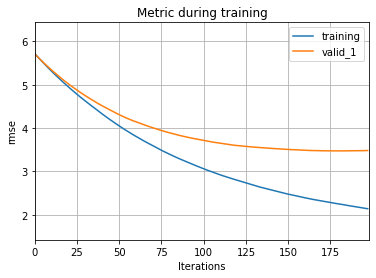

In [9]:
lgb.plot_metric(evals_result)

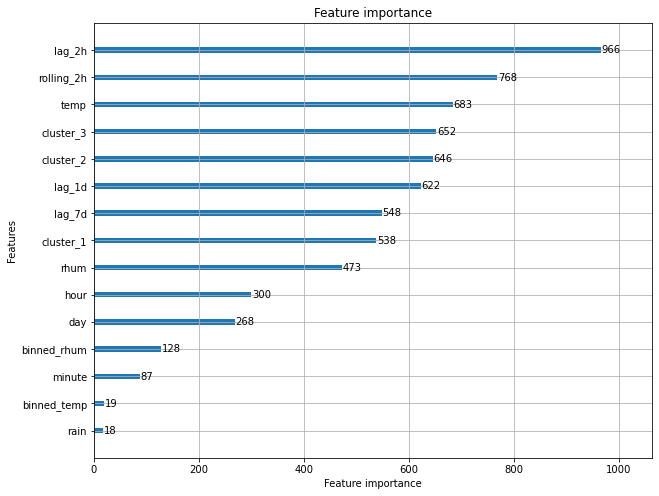

In [10]:
lgb.plot_importance(gbm, figsize=(10, 8))

# Eval Results

In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [12]:
# RMSE of forecasts
fc = gbm.predict(x_test, num_iteration=gbm.best_iteration)
rmse(fc, y_test)

3.476983776613836

In [13]:
# RMSE if forecast equals mean availability
fc = np.repeat(np.mean(df.available_bikes), len(y_test))
rmse(fc, y_test)

5.751727529823843